In [19]:
import pandas as pd

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error, mean_squared_error

In [6]:

import pickle

In [ ]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

2026/02/26 13:54:09 INFO mlflow.tracking.fluent: Experiment with name 'nyc-µtaxi-experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/3', creation_time=1772114049023, experiment_id='3', last_update_time=1772114049023, lifecycle_stage='active', name='nyc-µtaxi-experiment', tags={}>

In [8]:
def read_dataframe(url):
    df = pd.read_parquet(url)
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[((df.duration >=1) & (df.duration <=60))]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [9]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [10]:
len(df_train), len(df_val)

(73908, 61921)

In [11]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [ ]:
categorical = ['PU_DO']#'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [13]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [21]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
root_mean_squared_error(y_val, y_pred)

7.758715200888857

In [15]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr),f_out)

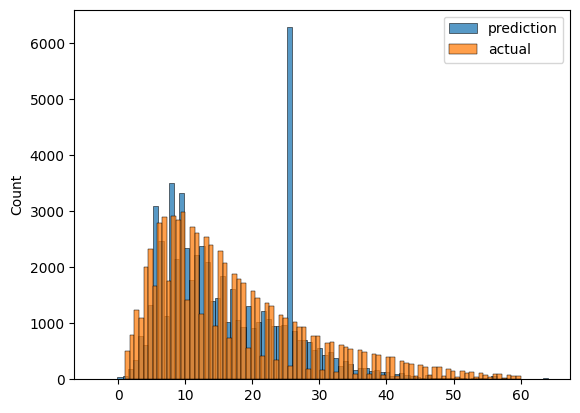

In [16]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='actual')

plt.legend()

In [ ]:
with mlflow.start_run():

    mlflow.set_tag("developer","clément")
    
    mlflow.log_param("train_data_path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("validation_data_path", "./data/green_tripdata_2021-02.parquet")

    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

/tmp/ipykernel_2768/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_2768/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


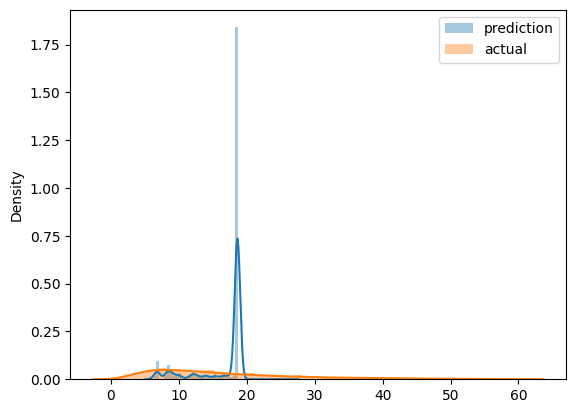

In [18]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

- Ridge 0.001 = 6.398
- Lasso 0.001 = 6.62
- LinearRegression = 6.098

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_train)

In [36]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [37]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [41]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params = params,
            dtrain = train,
            num_boost_round = 1000,
            evals = [(valid, "validation")],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)
    
    return {'loss': rmse, 'status': STATUS_OK}

In [42]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42,
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:02:03] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.58947                          
[1]	validation-rmse:11.02933                          
[2]	validation-rmse:10.52647                          
[3]	validation-rmse:10.07744                          
[4]	validation-rmse:9.67637                           
[5]	validation-rmse:9.31983                           
[6]	validation-rmse:9.00285                           
[7]	validation-rmse:8.72200                           
[8]	validation-rmse:8.47346                           
[9]	validation-rmse:8.25360                           
[10]	validation-rmse:8.06110                          
[11]	validation-rmse:7.89103                          
[12]	validation-rmse:7.74047                          
[13]	validation-rmse:7.60844                          
[14]	validation-rmse:7.49336                          
[15]	validation-rmse:7.39239                          
[16]	validation-rmse:7.30303                          
[17]	validation-rmse:7.22447                          
[18]	valid

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:03:14] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.27522                                                   
[1]	validation-rmse:10.47835                                                   
[2]	validation-rmse:9.80603                                                    
[3]	validation-rmse:9.24165                                                    
[4]	validation-rmse:8.76986                                                    
[5]	validation-rmse:8.37792                                                    
[6]	validation-rmse:8.05357                                                    
[7]	validation-rmse:7.78559                                                    
[8]	validation-rmse:7.56494                                                    
[9]	validation-rmse:7.38455                                                    
[10]	validation-rmse:7.23728                                                   
[11]	validation-rmse:7.11595                                                   
[12]	validation-rmse:7.01589            

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:05:37] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:7.17753                                                       
[4]	validation-rmse:6.98148                                                       
[5]	validation-rmse:6.87624                                                       
[6]	validation-rmse:6.81924                                                       
[7]	validation-rmse:6.78378                                                       
[8]	validation-rmse:6.75742                                                       
[9]	validation-rmse:6.74473                                                       
[10]	validation-rmse:6.73473                                                      
[11]	validation-rmse:6.73292                                                      
[12]	validation-rmse:6.72725                                                      
[13]	validation-rmse:6.72254                                                      
[14]	validation-rmse:6.71915                                                      
[15]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:06:34] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.75769                                                    
[1]	validation-rmse:11.33523                                                    
[2]	validation-rmse:10.94385                                                    
[3]	validation-rmse:10.58171                                                    
[4]	validation-rmse:10.24692                                                    
[5]	validation-rmse:9.93788                                                     
[6]	validation-rmse:9.65287                                                     
[7]	validation-rmse:9.39031                                                     
[8]	validation-rmse:9.14852                                                     
[9]	validation-rmse:8.92630                                                     
[10]	validation-rmse:8.72269                                                    
[11]	validation-rmse:8.53646                                                    
[12]	validation-rmse:8.36529

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:10:04] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.93269                                                      
[1]	validation-rmse:7.00636                                                      
[2]	validation-rmse:6.80846                                                      
[3]	validation-rmse:6.74424                                                      
[4]	validation-rmse:6.72369                                                      
[5]	validation-rmse:6.70858                                                      
[6]	validation-rmse:6.70500                                                      
[7]	validation-rmse:6.70294                                                      
[8]	validation-rmse:6.69470                                                      
[9]	validation-rmse:6.69183                                                      
[10]	validation-rmse:6.68942                                                     
[11]	validation-rmse:6.68738                                                     
[12]	validation-

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:10:42] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.08699                                                     
[1]	validation-rmse:10.16860                                                     
[2]	validation-rmse:9.42674                                                      
[3]	validation-rmse:8.83464                                                      
[4]	validation-rmse:8.36826                                                      
[5]	validation-rmse:7.99151                                                      
[6]	validation-rmse:7.70110                                                      
[7]	validation-rmse:7.46818                                                      
[8]	validation-rmse:7.29124                                                      
[9]	validation-rmse:7.15079                                                      
[10]	validation-rmse:7.03802                                                     
[11]	validation-rmse:6.95302                                                     
[12]	validation-

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:13:05] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.15030                                                     
[1]	validation-rmse:8.78836                                                      
[2]	validation-rmse:7.91754                                                      
[3]	validation-rmse:7.37209                                                      
[4]	validation-rmse:7.03655                                                      
[5]	validation-rmse:6.82883                                                      
[6]	validation-rmse:6.70167                                                      
[7]	validation-rmse:6.61693                                                      
[8]	validation-rmse:6.56381                                                      
[9]	validation-rmse:6.52540                                                      
[10]	validation-rmse:6.49888                                                     
[11]	validation-rmse:6.47899                                                     
[12]	validation-

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:14:07] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.33509                                                      
[1]	validation-rmse:7.91497                                                      
[2]	validation-rmse:7.25882                                                      
[3]	validation-rmse:6.95924                                                      
[4]	validation-rmse:6.81634                                                      
[5]	validation-rmse:6.74212                                                      
[6]	validation-rmse:6.70236                                                      
[7]	validation-rmse:6.67886                                                      
[8]	validation-rmse:6.66180                                                      
[9]	validation-rmse:6.65219                                                      
[10]	validation-rmse:6.64438                                                     
[11]	validation-rmse:6.64008                                                     
[12]	validation-

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:15:30] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.86640                                                      
[1]	validation-rmse:6.64972                                                      
[2]	validation-rmse:6.62432                                                      
[3]	validation-rmse:6.61794                                                      
[4]	validation-rmse:6.60725                                                      
[5]	validation-rmse:6.60137                                                      
[6]	validation-rmse:6.59535                                                      
[7]	validation-rmse:6.58781                                                      
[8]	validation-rmse:6.58232                                                      
[9]	validation-rmse:6.57631                                                      
[10]	validation-rmse:6.56705                                                     
[11]	validation-rmse:6.56033                                                     
[12]	validation-

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:16:09] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.99822                                                    
[1]	validation-rmse:6.67219                                                    
[2]	validation-rmse:6.60850                                                    
[3]	validation-rmse:6.59494                                                    
[4]	validation-rmse:6.58665                                                    
[5]	validation-rmse:6.57486                                                    
[6]	validation-rmse:6.56855                                                    
[7]	validation-rmse:6.56333                                                    
[8]	validation-rmse:6.55836                                                    
[9]	validation-rmse:6.54627                                                    
[10]	validation-rmse:6.54287                                                   
[11]	validation-rmse:6.53734                                                   
[12]	validation-rmse:6.53575            

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:16:34] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.81116                                                    
[1]	validation-rmse:11.43551                                                    
[2]	validation-rmse:11.08466                                                    
[3]	validation-rmse:10.75737                                                    
[4]	validation-rmse:10.45219                                                    
[5]	validation-rmse:10.16779                                                    
[6]	validation-rmse:9.90330                                                     
[7]	validation-rmse:9.65768                                                     
[8]	validation-rmse:9.42963                                                     
[9]	validation-rmse:9.21817                                                     
[10]	validation-rmse:9.02218                                                    
[11]	validation-rmse:8.84072                                                    
[12]	validation-rmse:8.67292

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:18:27] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.68692                                                     
[1]	validation-rmse:7.36570                                                     
[2]	validation-rmse:6.88439                                                     
[3]	validation-rmse:6.71648                                                     
[4]	validation-rmse:6.62469                                                     
[5]	validation-rmse:6.58616                                                     
[6]	validation-rmse:6.56276                                                     
[7]	validation-rmse:6.54295                                                     
[8]	validation-rmse:6.53508                                                     
[9]	validation-rmse:6.52929                                                     
[10]	validation-rmse:6.52563                                                    
[11]	validation-rmse:6.52341                                                    
[12]	validation-rmse:6.51933

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:19:18] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.16216                                                     
[1]	validation-rmse:7.04314                                                     
[2]	validation-rmse:6.74352                                                     
[3]	validation-rmse:6.65380                                                     
[4]	validation-rmse:6.62149                                                     
[5]	validation-rmse:6.60406                                                     
[6]	validation-rmse:6.59931                                                     
[7]	validation-rmse:6.58998                                                     
[8]	validation-rmse:6.58800                                                     
[9]	validation-rmse:6.58199                                                     
[10]	validation-rmse:6.57524                                                    
[11]	validation-rmse:6.57060                                                    
[12]	validation-rmse:6.56726

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:19:49] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:6.85216                                                     
[5]	validation-rmse:6.84641                                                     
[6]	validation-rmse:6.83924                                                     
[7]	validation-rmse:6.83502                                                     
[8]	validation-rmse:6.82822                                                     
[9]	validation-rmse:6.82409                                                     
[10]	validation-rmse:6.81469                                                    
[11]	validation-rmse:6.81229                                                    
[12]	validation-rmse:6.80859                                                    
[13]	validation-rmse:6.80672                                                    
[14]	validation-rmse:6.80509                                                    
[15]	validation-rmse:6.80306                                                    
[16]	validation-rmse:6.80450

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:20:29] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.48770                                                     
[1]	validation-rmse:8.06860                                                     
[2]	validation-rmse:7.37685                                                     
[3]	validation-rmse:7.04192                                                     
[4]	validation-rmse:6.87308                                                     
[5]	validation-rmse:6.78509                                                     
[6]	validation-rmse:6.73897                                                     
[7]	validation-rmse:6.71086                                                     
[8]	validation-rmse:6.69163                                                     
[9]	validation-rmse:6.68355                                                     
[10]	validation-rmse:6.67390                                                    
[11]	validation-rmse:6.67156                                                    
[12]	validation-rmse:6.66689

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:21:24] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:10.34229                                                    
[4]	validation-rmse:9.97732                                                     
[5]	validation-rmse:9.64757                                                     
[6]	validation-rmse:9.34953                                                     
[7]	validation-rmse:9.08091                                                     
[8]	validation-rmse:8.83947                                                     
[9]	validation-rmse:8.62271                                                     
[10]	validation-rmse:8.42797                                                    
[11]	validation-rmse:8.25401                                                    
[12]	validation-rmse:8.09808                                                    
[13]	validation-rmse:7.95904                                                    
[14]	validation-rmse:7.83533                                                    
[15]	validation-rmse:7.72428

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:22:15] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.38591                                                    
[1]	validation-rmse:10.67136                                                    
[2]	validation-rmse:10.05655                                                    
[3]	validation-rmse:9.52419                                                     
[4]	validation-rmse:9.07202                                                     
[5]	validation-rmse:8.68809                                                     
[6]	validation-rmse:8.36347                                                     
[7]	validation-rmse:8.08352                                                     
[8]	validation-rmse:7.85346                                                     
[9]	validation-rmse:7.65966                                                     
[10]	validation-rmse:7.49227                                                    
[11]	validation-rmse:7.35098                                                    
[12]	validation-rmse:7.23479

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:24:26] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.33147                                                     
[1]	validation-rmse:7.87805                                                     
[2]	validation-rmse:7.18890                                                     
[3]	validation-rmse:6.86570                                                     
[4]	validation-rmse:6.71208                                                     
[5]	validation-rmse:6.63389                                                     
[6]	validation-rmse:6.58293                                                     
[7]	validation-rmse:6.55080                                                     
[8]	validation-rmse:6.53387                                                     
[9]	validation-rmse:6.52026                                                     
[10]	validation-rmse:6.50735                                                    
[11]	validation-rmse:6.49704                                                    
[12]	validation-rmse:6.49341

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:25:23] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.61362                                                    
[1]	validation-rmse:11.07063                                                    
[2]	validation-rmse:10.57946                                                    
[3]	validation-rmse:10.13685                                                    
[4]	validation-rmse:9.73875                                                     
[5]	validation-rmse:9.38058                                                     
[6]	validation-rmse:9.05971                                                     
[7]	validation-rmse:8.77144                                                     
[8]	validation-rmse:8.51434                                                     
[9]	validation-rmse:8.28612                                                     
[10]	validation-rmse:8.08135                                                    
[11]	validation-rmse:7.90036                                                    
[12]	validation-rmse:7.73884

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:29:30] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.86942                                                        
[1]	validation-rmse:7.51156                                                        
[2]	validation-rmse:6.98338                                                        
[3]	validation-rmse:6.76398                                                        
[4]	validation-rmse:6.67067                                                        
[5]	validation-rmse:6.62167                                                        
[6]	validation-rmse:6.59916                                                        
[7]	validation-rmse:6.58435                                                        
[8]	validation-rmse:6.57327                                                        
[9]	validation-rmse:6.56833                                                        
[10]	validation-rmse:6.56516                                                       
[11]	validation-rmse:6.55976                                                

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:30:15] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.38343                                                    
[1]	validation-rmse:9.10334                                                     
[2]	validation-rmse:8.22536                                                     
[3]	validation-rmse:7.63919                                                     
[4]	validation-rmse:7.25401                                                     
[5]	validation-rmse:6.99864                                                     
[6]	validation-rmse:6.82851                                                     
[7]	validation-rmse:6.71962                                                     
[8]	validation-rmse:6.64038                                                     
[9]	validation-rmse:6.58862                                                     
[10]	validation-rmse:6.55022                                                    
[11]	validation-rmse:6.52347                                                    
[12]	validation-rmse:6.50389

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:31:27] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.56347                                                    
[1]	validation-rmse:9.35627                                                     
[2]	validation-rmse:8.48844                                                     
[3]	validation-rmse:7.87368                                                     
[4]	validation-rmse:7.44940                                                     
[5]	validation-rmse:7.15434                                                     
[6]	validation-rmse:6.94993                                                     
[7]	validation-rmse:6.80970                                                     
[8]	validation-rmse:6.70898                                                     
[9]	validation-rmse:6.63940                                                     
[10]	validation-rmse:6.59179                                                    
[11]	validation-rmse:6.55354                                                    
[12]	validation-rmse:6.52444

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:32:44] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.87733                                                    
[1]	validation-rmse:9.82956                                                     
[2]	validation-rmse:9.01669                                                     
[3]	validation-rmse:8.39008                                                     
[4]	validation-rmse:7.91781                                                     
[5]	validation-rmse:7.56172                                                     
[6]	validation-rmse:7.29579                                                     
[7]	validation-rmse:7.09761                                                     
[8]	validation-rmse:6.94979                                                     
[9]	validation-rmse:6.83543                                                     
[10]	validation-rmse:6.74957                                                    
[11]	validation-rmse:6.68482                                                    
[12]	validation-rmse:6.63481

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:34:45] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.42939                                                    
[1]	validation-rmse:10.74327                                                    
[2]	validation-rmse:10.14462                                                    
[3]	validation-rmse:9.62482                                                     
[4]	validation-rmse:9.17359                                                     
[5]	validation-rmse:8.78398                                                     
[6]	validation-rmse:8.44947                                                     
[7]	validation-rmse:8.16290                                                     
[8]	validation-rmse:7.91796                                                     
[9]	validation-rmse:7.70879                                                     
[10]	validation-rmse:7.52954                                                    
[11]	validation-rmse:7.37821                                                    
[12]	validation-rmse:7.24896

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:37:10] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.48247                                                     
[1]	validation-rmse:10.83673                                                     
[2]	validation-rmse:10.26740                                                     
[3]	validation-rmse:9.76781                                                      
[4]	validation-rmse:9.32988                                                      
[5]	validation-rmse:8.94620                                                      
[6]	validation-rmse:8.61390                                                      
[7]	validation-rmse:8.32396                                                      
[8]	validation-rmse:8.07382                                                      
[9]	validation-rmse:7.85827                                                      
[10]	validation-rmse:7.67141                                                     
[11]	validation-rmse:7.51055                                                     
[12]	validation-

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:40:09] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.65355                                                     
[1]	validation-rmse:11.14271                                                     
[2]	validation-rmse:10.67791                                                     
[3]	validation-rmse:10.25523                                                     
[4]	validation-rmse:9.87209                                                      
[5]	validation-rmse:9.52493                                                      
[6]	validation-rmse:9.21018                                                      
[7]	validation-rmse:8.92637                                                      
[8]	validation-rmse:8.67101                                                      
[9]	validation-rmse:8.44140                                                      
[10]	validation-rmse:8.23472                                                     
[11]	validation-rmse:8.04947                                                     
[12]	validation-

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:44:31] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.74067                                                       
[1]	validation-rmse:11.30359                                                       
[2]	validation-rmse:10.89897                                                       
[3]	validation-rmse:10.52578                                                       
[4]	validation-rmse:10.18160                                                       
[5]	validation-rmse:9.86464                                                        
[6]	validation-rmse:9.57338                                                        
[7]	validation-rmse:9.30566                                                        
[8]	validation-rmse:9.05920                                                        
[9]	validation-rmse:8.83431                                                        
[10]	validation-rmse:8.62782                                                       
[11]	validation-rmse:8.43868                                                

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:47:52] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.79600                                                      
[1]	validation-rmse:11.40573                                                      
[2]	validation-rmse:11.04091                                                      
[3]	validation-rmse:10.70109                                                      
[4]	validation-rmse:10.38498                                                      
[5]	validation-rmse:10.09102                                                      
[6]	validation-rmse:9.81657                                                       
[7]	validation-rmse:9.56227                                                       
[8]	validation-rmse:9.32601                                                       
[9]	validation-rmse:9.10687                                                       
[10]	validation-rmse:8.90424                                                      
[11]	validation-rmse:8.71674                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:51:17] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.75197                                                      
[1]	validation-rmse:11.32404                                                      
[2]	validation-rmse:10.92688                                                      
[3]	validation-rmse:10.55994                                                      
[4]	validation-rmse:10.22127                                                      
[5]	validation-rmse:9.90881                                                       
[6]	validation-rmse:9.61966                                                       
[7]	validation-rmse:9.35422                                                       
[8]	validation-rmse:9.10880                                                       
[9]	validation-rmse:8.88346                                                       
[10]	validation-rmse:8.67735                                                      
[11]	validation-rmse:8.48855                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:54:58] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.19078                                                      
[1]	validation-rmse:10.33934                                                      
[2]	validation-rmse:9.63776                                                       
[3]	validation-rmse:9.06049                                                       
[4]	validation-rmse:8.59116                                                       
[5]	validation-rmse:8.20221                                                       
[6]	validation-rmse:7.89205                                                       
[7]	validation-rmse:7.64506                                                       
[8]	validation-rmse:7.44115                                                       
[9]	validation-rmse:7.27663                                                       
[10]	validation-rmse:7.14840                                                      
[11]	validation-rmse:7.04111                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:57:21] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.80164                                                      
[1]	validation-rmse:11.41791                                                      
[2]	validation-rmse:11.05974                                                      
[3]	validation-rmse:10.72570                                                      
[4]	validation-rmse:10.41502                                                      
[5]	validation-rmse:10.12525                                                      
[6]	validation-rmse:9.85642                                                       
[7]	validation-rmse:9.60512                                                       
[8]	validation-rmse:9.37569                                                       
[9]	validation-rmse:9.15915                                                       
[10]	validation-rmse:8.96163                                                      
[11]	validation-rmse:8.77861                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:00:43] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.52111                                                    
[1]	validation-rmse:10.90671                                                    
[2]	validation-rmse:10.36163                                                    
[3]	validation-rmse:9.87931                                                     
[4]	validation-rmse:9.45472                                                     
[5]	validation-rmse:9.08118                                                     
[6]	validation-rmse:8.75280                                                     
[7]	validation-rmse:8.46631                                                     
[8]	validation-rmse:8.21689                                                     
[9]	validation-rmse:7.99818                                                     
[10]	validation-rmse:7.80764                                                    
[11]	validation-rmse:7.64273                                                    
[12]	validation-rmse:7.50055

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:02:54] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.83724                                                      
[1]	validation-rmse:9.77391                                                       
[2]	validation-rmse:8.96964                                                       
[3]	validation-rmse:8.35632                                                       
[4]	validation-rmse:7.90036                                                       
[5]	validation-rmse:7.56222                                                       
[6]	validation-rmse:7.30655                                                       
[7]	validation-rmse:7.12763                                                       
[8]	validation-rmse:6.99607                                                       
[9]	validation-rmse:6.88677                                                       
[10]	validation-rmse:6.80723                                                      
[11]	validation-rmse:6.75165                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:04:49] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.72090                                                      
[1]	validation-rmse:11.26681                                                      
[2]	validation-rmse:10.84909                                                      
[3]	validation-rmse:10.46481                                                      
[4]	validation-rmse:10.11205                                                      
[5]	validation-rmse:9.78828                                                       
[6]	validation-rmse:9.49159                                                       
[7]	validation-rmse:9.22090                                                       
[8]	validation-rmse:8.97411                                                       
[9]	validation-rmse:8.74872                                                       
[10]	validation-rmse:8.54321                                                      
[11]	validation-rmse:8.35656                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:07:22] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.28854                                                      
[1]	validation-rmse:10.50477                                                      
[2]	validation-rmse:9.84557                                                       
[3]	validation-rmse:9.28791                                                       
[4]	validation-rmse:8.82555                                                       
[5]	validation-rmse:8.43524                                                       
[6]	validation-rmse:8.11162                                                       
[7]	validation-rmse:7.84851                                                       
[8]	validation-rmse:7.63475                                                       
[9]	validation-rmse:7.45069                                                       
[10]	validation-rmse:7.30200                                                      
[11]	validation-rmse:7.18241                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:10:00] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.54286                                                      
[1]	validation-rmse:10.94717                                                      
[2]	validation-rmse:10.41789                                                      
[3]	validation-rmse:9.94746                                                       
[4]	validation-rmse:9.53104                                                       
[5]	validation-rmse:9.16678                                                       
[6]	validation-rmse:8.84381                                                       
[7]	validation-rmse:8.55632                                                       
[8]	validation-rmse:8.31310                                                       
[9]	validation-rmse:8.09439                                                       
[10]	validation-rmse:7.89662                                                      
[11]	validation-rmse:7.73380                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:13:44] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.03218                                                      
[1]	validation-rmse:8.64374                                                       
[2]	validation-rmse:7.78943                                                       
[3]	validation-rmse:7.27782                                                       
[4]	validation-rmse:6.97339                                                       
[5]	validation-rmse:6.79187                                                       
[6]	validation-rmse:6.68008                                                       
[7]	validation-rmse:6.61028                                                       
[8]	validation-rmse:6.56227                                                       
[9]	validation-rmse:6.52927                                                       
[10]	validation-rmse:6.50563                                                      
[11]	validation-rmse:6.49023                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:14:35] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.99919                                                      
[1]	validation-rmse:10.02615                                                      
[2]	validation-rmse:9.25333                                                       
[3]	validation-rmse:8.64540                                                       
[4]	validation-rmse:8.17193                                                       
[5]	validation-rmse:7.80510                                                       
[6]	validation-rmse:7.52177                                                       
[7]	validation-rmse:7.30357                                                       
[8]	validation-rmse:7.13627                                                       
[9]	validation-rmse:7.00940                                                       
[10]	validation-rmse:6.90986                                                      
[11]	validation-rmse:6.83532                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:16:16] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.69072                                                      
[1]	validation-rmse:11.21091                                                      
[2]	validation-rmse:10.77076                                                      
[3]	validation-rmse:10.36855                                                      
[4]	validation-rmse:10.00004                                                      
[5]	validation-rmse:9.66561                                                       
[6]	validation-rmse:9.36049                                                       
[7]	validation-rmse:9.08143                                                       
[8]	validation-rmse:8.82931                                                       
[9]	validation-rmse:8.60087                                                       
[10]	validation-rmse:8.39360                                                      
[11]	validation-rmse:8.20542                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:20:03] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.79252                                                      
[1]	validation-rmse:11.39911                                                      
[2]	validation-rmse:11.03235                                                      
[3]	validation-rmse:10.69031                                                      
[4]	validation-rmse:10.37160                                                      
[5]	validation-rmse:10.07512                                                      
[6]	validation-rmse:9.79903                                                       
[7]	validation-rmse:9.54265                                                       
[8]	validation-rmse:9.30555                                                       
[9]	validation-rmse:9.08487                                                       
[10]	validation-rmse:8.88079                                                      
[11]	validation-rmse:8.69102                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:25:32] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.13578                                                      
[1]	validation-rmse:10.24712                                                      
[2]	validation-rmse:9.51905                                                       
[3]	validation-rmse:8.92715                                                       
[4]	validation-rmse:8.44937                                                       
[5]	validation-rmse:8.06590                                                       
[6]	validation-rmse:7.75963                                                       
[7]	validation-rmse:7.51683                                                       
[8]	validation-rmse:7.32419                                                       
[9]	validation-rmse:7.17247                                                       
[10]	validation-rmse:7.05243                                                      
[11]	validation-rmse:6.95748                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:27:27] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.31007                                                      
[1]	validation-rmse:10.54155                                                      
[2]	validation-rmse:9.88817                                                       
[3]	validation-rmse:9.33717                                                       
[4]	validation-rmse:8.87509                                                       
[5]	validation-rmse:8.48615                                                       
[6]	validation-rmse:8.16607                                                       
[7]	validation-rmse:7.89032                                                       
[8]	validation-rmse:7.66382                                                       
[9]	validation-rmse:7.48219                                                       
[10]	validation-rmse:7.33026                                                      
[11]	validation-rmse:7.19964                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:30:27] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.61448                                                      
[1]	validation-rmse:9.44754                                                       
[2]	validation-rmse:8.60678                                                       
[3]	validation-rmse:8.01509                                                       
[4]	validation-rmse:7.58731                                                       
[5]	validation-rmse:7.29646                                                       
[6]	validation-rmse:7.09849                                                       
[7]	validation-rmse:6.94628                                                       
[8]	validation-rmse:6.84845                                                       
[9]	validation-rmse:6.77298                                                       
[10]	validation-rmse:6.71991                                                      
[11]	validation-rmse:6.67714                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:31:55] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.88126                                                       
[1]	validation-rmse:8.48367                                                       
[2]	validation-rmse:7.68086                                                       
[3]	validation-rmse:7.23244                                                       
[4]	validation-rmse:6.98289                                                       
[5]	validation-rmse:6.84081                                                       
[6]	validation-rmse:6.74973                                                       
[7]	validation-rmse:6.69713                                                       
[8]	validation-rmse:6.66379                                                       
[9]	validation-rmse:6.64073                                                       
[10]	validation-rmse:6.62505                                                      
[11]	validation-rmse:6.61380                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:33:10] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.13368                                                       
[1]	validation-rmse:6.66601                                                       
[2]	validation-rmse:6.59981                                                       
[3]	validation-rmse:6.57721                                                       
[4]	validation-rmse:6.57318                                                       
[5]	validation-rmse:6.56460                                                       
[6]	validation-rmse:6.55792                                                       
[7]	validation-rmse:6.54883                                                       
[8]	validation-rmse:6.54310                                                       
[9]	validation-rmse:6.53796                                                       
[10]	validation-rmse:6.53122                                                      
[11]	validation-rmse:6.52433                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:33:31] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:11.35801                                                     
[2]	validation-rmse:10.97652                                                     
[3]	validation-rmse:10.62323                                                     
[4]	validation-rmse:10.29672                                                     
[5]	validation-rmse:9.99490                                                      
[6]	validation-rmse:9.71720                                                      
[7]	validation-rmse:9.46090                                                      
[8]	validation-rmse:9.22548                                                      
[9]	validation-rmse:9.00867                                                      
[10]	validation-rmse:8.81036                                                     
[11]	validation-rmse:8.62790                                                     
[12]	validation-rmse:8.46064                                                     
[13]	validation-

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:34:36] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.59250                                                     
[1]	validation-rmse:11.03499                                                     
[2]	validation-rmse:10.53557                                                     
[3]	validation-rmse:10.08932                                                     
[4]	validation-rmse:9.69146                                                      
[5]	validation-rmse:9.33755                                                      
[6]	validation-rmse:9.02361                                                      
[7]	validation-rmse:8.74572                                                      
[8]	validation-rmse:8.50019                                                      
[9]	validation-rmse:8.28355                                                      
[10]	validation-rmse:8.09298                                                     
[11]	validation-rmse:7.92566                                                     
[12]	validation-

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:36:11] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.76527                                                      
[1]	validation-rmse:6.88755                                                      
[2]	validation-rmse:6.70436                                                      
[3]	validation-rmse:6.65822                                                      
[4]	validation-rmse:6.63006                                                      
[5]	validation-rmse:6.61957                                                      
[6]	validation-rmse:6.61030                                                      
[7]	validation-rmse:6.60694                                                      
[8]	validation-rmse:6.60115                                                      
[9]	validation-rmse:6.59764                                                      
[10]	validation-rmse:6.59315                                                     
[11]	validation-rmse:6.59007                                                     
[12]	validation-

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:36:47] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.41003                                                     
[1]	validation-rmse:10.70865                                                     
[2]	validation-rmse:10.10042                                                     
[3]	validation-rmse:9.57432                                                      
[4]	validation-rmse:9.12001                                                      
[5]	validation-rmse:8.72762                                                      
[6]	validation-rmse:8.39185                                                      
[7]	validation-rmse:8.10677                                                      
[8]	validation-rmse:7.86394                                                      
[9]	validation-rmse:7.65744                                                      
[10]	validation-rmse:7.48256                                                     
[11]	validation-rmse:7.33445                                                     
[12]	validation-

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:39:13] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.60325                                                     
[1]	validation-rmse:11.05726                                                     
[2]	validation-rmse:10.56147                                                     
[3]	validation-rmse:10.11918                                                     
[4]	validation-rmse:9.71975                                                      
[5]	validation-rmse:9.36601                                                      
[6]	validation-rmse:9.04609                                                      
[7]	validation-rmse:8.76538                                                      
[8]	validation-rmse:8.51201                                                      
[9]	validation-rmse:8.28944                                                      
[10]	validation-rmse:8.09061                                                     
[11]	validation-rmse:7.91641                                                     
[12]	validation-

In [43]:
params ={
    "learning_rate": "0.05766617027903694",
    "max_depth": "60",
    "min_child_weight": "1.145268038914493",
    "objective": "reg:linear",
    "reg_alpha": "0.23733420462104748",
    "reg_lambda": "0.30642470632441215",
    "seed": "42",
}

mlflow.xgboost.autolog()

booster = xgb.train(
            params = params,
            dtrain = train,
            num_boost_round = 1000,
            evals = [(valid, "validation")],
            early_stopping_rounds=50
        )

2026/02/26 16:43:02 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7090099000de4b1b8c9ee603faed18fb', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:43:05] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:11.74067
[1]	validation-rmse:11.30359
[2]	validation-rmse:10.89897
[3]	validation-rmse:10.52578
[4]	validation-rmse:10.18160
[5]	validation-rmse:9.86464
[6]	validation-rmse:9.57338
[7]	validation-rmse:9.30566
[8]	validation-rmse:9.05920
[9]	validation-rmse:8.83431
[10]	validation-rmse:8.62782
[11]	validation-rmse:8.43868
[12]	validation-rmse:8.26674
[13]	validation-rmse:8.10921
[14]	validation-rmse:7.96417
[15]	validation-rmse:7.83370
[16]	validation-rmse:7.71499
[17]	validation-rmse:7.60719
[18]	validation-rmse:7.50748
[19]	validation-rmse:7.41869
[20]	validation-rmse:7.33615
[21]	validation-rmse:7.26204
[22]	validation-rmse:7.19415
[23]	validation-rmse:7.13182
[24]	validation-rmse:7.07600
[25]	validation-rmse:7.02461
[26]	validation-rmse:6.97801
[27]	validation-rmse:6.93552
[28]	validation-rmse:6.89738
[29]	validation-rmse:6.86131
[30]	validation-rmse:6.82962
[31]	validation-rmse:6.79973
[32]	validation-rmse:6.77321
[33]	validation-rmse:6.74843
[34]	validation-rms

2026/02/26 16:46:36 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2026/02/26 16:46:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/26 16:46:36 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:46:36] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2026/02/26 16:46:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
